# A Multi-class classifier

In [23]:
import torch
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [24]:
# Generate data in blobs
RANDOM_SEED=42
NB_FEATURES=2
NB_BLOBS=4
X_set,y_set = make_blobs(n_samples=2000, n_features=NB_FEATURES, centers=NB_BLOBS, cluster_std=1.5, random_state=RANDOM_SEED)


tensor([[ 4.4471, -0.8496],
        [ 5.4521,  3.1119],
        [-8.9062, -8.8638],
        [-8.9192,  5.8501],
        [-5.8510,  6.0754]]) tensor([1, 1, 2, 3, 3])


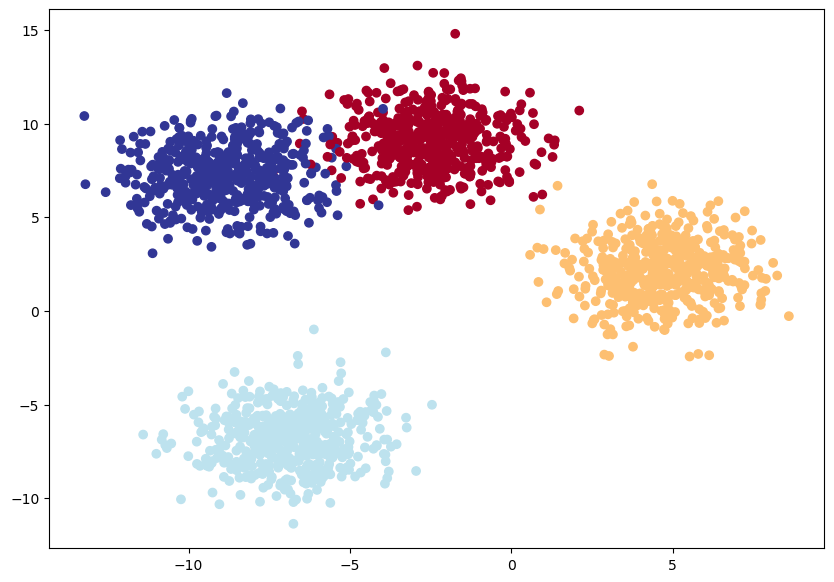

In [25]:
# transform as tensors
X = torch.from_numpy(X_set).type(torch.float)
y = torch.from_numpy(y_set).type(torch.LongTensor)
print(X[:5], y[:5])
# build train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

# Build the Neural Network


In [34]:
from torch import nn

device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"

class BlobsClassifier(nn.Module):
    def __init__(self,input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            #nn.ReLU()
        )       
        
    def forward(self,x):
        return self.linear_layer_stack(x)
model=BlobsClassifier(input_features=NB_FEATURES,output_features=NB_BLOBS).to(device)
model

BlobsClassifier(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [35]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates if two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [36]:
loss_fn=nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(params=model.parameters(), lr=0.1)

In [37]:
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [38]:
# One forward inference
model(X_train)[:5]
# model is predicting one value for each class that we have.

tensor([[-0.2052, -1.1862, -0.8340, -0.1958],
        [-0.8060, -0.6984, -1.5669, -1.1101],
        [-0.1750, -1.1190, -0.7658, -0.1776],
        [-0.1770, -1.1185, -0.7818, -0.1904],
        [-0.1301, -0.9995, -0.7118, -0.1980]], device='mps:0',
       grad_fn=<SliceBackward0>)

In [41]:
# To move to a class label, we need to map those 4 number per input to a probability to part of the matching class
# The softmax function calculates the probability of each prediction class being the actual predicted 
# class compared to all other possible classes.
y_logits = model(X_test)

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])
# the sum for each element is close to 1
print(torch.sum(y_pred_probs[0]))
# These prediction probablities are essentially saying how much the model thinks the target X sample 
# (the input) maps to each class.

# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([[-0.2894, -1.3390, -1.1107, -0.3323],
        [ 0.2509, -0.2392,  0.1828, -0.0027],
        [-0.1510, -1.0635, -0.7162, -0.1679],
        [ 0.2017, -0.3226,  0.0530,  0.0325],
        [-0.0797, -0.9061, -0.5512, -0.1212]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3639, 0.1274, 0.1601, 0.3486],
        [0.3010, 0.1844, 0.2812, 0.2335],
        [0.3386, 0.1360, 0.1924, 0.3330],
        [0.3032, 0.1795, 0.2613, 0.2560],
        [0.3310, 0.1449, 0.2066, 0.3176]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor(1., device='mps:0', grad_fn=<SumBackward0>)
tensor([0.3639, 0.1274, 0.1601, 0.3486], device='mps:0',
       grad_fn=<SelectBackward0>)
tensor(0, device='mps:0')


In [42]:
# Train the model and assess on test data
torch.manual_seed(RANDOM_SEED)
epochs=1000


for epoch in range(epochs):
    model.train()
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    # from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze() 
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.15461, Accuracy: 40.50% | Test loss: 1.07969, Test acc: 50.00
Epoch: 10 | Loss: 0.64710, Accuracy: 96.81% | Test loss: 0.64372, Test acc: 97.25
Epoch: 20 | Loss: 0.41452, Accuracy: 98.56% | Test loss: 0.41686, Test acc: 99.00
Epoch: 30 | Loss: 0.22759, Accuracy: 98.88% | Test loss: 0.22264, Test acc: 99.25
Epoch: 40 | Loss: 0.09908, Accuracy: 98.94% | Test loss: 0.09400, Test acc: 99.25
Epoch: 50 | Loss: 0.06340, Accuracy: 98.94% | Test loss: 0.05989, Test acc: 99.25
Epoch: 60 | Loss: 0.05055, Accuracy: 98.94% | Test loss: 0.04700, Test acc: 99.25
Epoch: 70 | Loss: 0.04439, Accuracy: 98.94% | Test loss: 0.04037, Test acc: 99.50
Epoch: 80 | Loss: 0.04074, Accuracy: 98.94% | Test loss: 0.03630, Test acc: 99.50
Epoch: 90 | Loss: 0.03834, Accuracy: 98.88% | Test loss: 0.03353, Test acc: 99.50
Epoch: 100 | Loss: 0.03668, Accuracy: 98.88% | Test loss: 0.03153, Test acc: 99.50
Epoch: 110 | Loss: 0.03546, Accuracy: 98.88% | Test loss: 0.03002, Test acc: 99.50
Epoch: 120 | Lo

In [43]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_test)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_preds)}%")

Predictions: tensor([0, 2, 3, 2, 3, 3, 1, 1, 3, 0], device='mps:0')
Labels: tensor([0, 2, 3, 2, 3, 3, 1, 1, 3, 0], device='mps:0')
Test accuracy: 99.5%


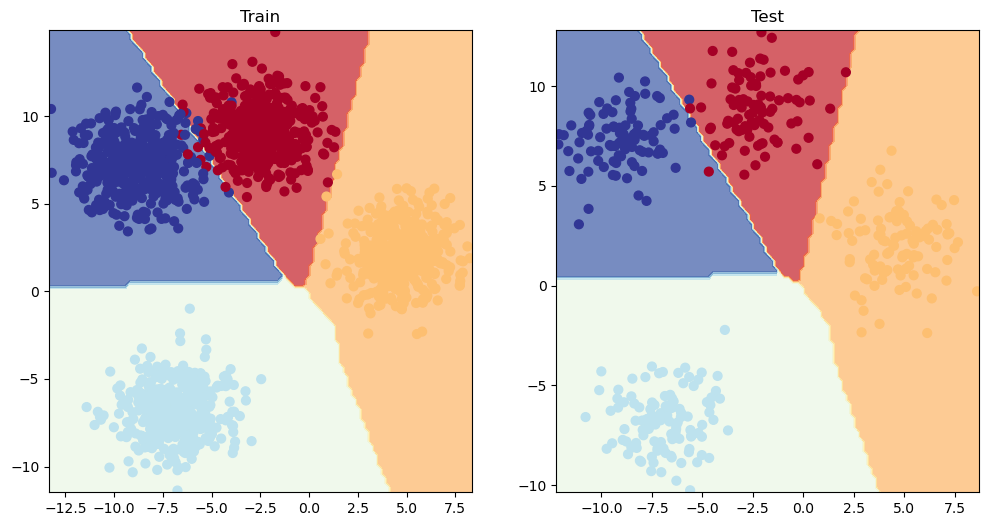

In [44]:
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)